In [81]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import os

from scipy.linalg import expm, eig, eigh, svd, norm

from qiskit import transpile
from qiskit import qpy
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService as QRS

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper

from TFIM_generator import generate_TFIM_gates 
pi = np.pi

def print_matrix(mat):
    for i in mat:
        print("| ", end ="")
        for j in range(len(i)):
            if j != len(i)-1: print(f"{i[j]:10}", end="\t\t")
            else: print(i[j], end="")
        print(" |")

In [82]:
def create_hamiltonian(parameters, show_steps=False):
    '''
    Create a system hamiltonian for the following systems:
     - Tranverse Field Ising Model (TFI)
     - Heisenberg Spin Model (SPI)
     - Hubbard Model (HUB)
     - Dihydrogen (H_2)

    Parameters:
     - parameters: a dictionary of parameters for contructing
       the Hamiltonian containing the following information
        - system: the system written as either: TFI, SPI, HUB, H_2
        - particles: the number of particles, default is 2
        - scaling: scales the eigenvalues to be at most this number
        - shifting: shift the eigenvalues by this value
        system specific parameters:
        TFI
        - g: magnetic field strength
        SPI
        - J: coupling strength
        HUB
        - t: left-right hopping
        - U: up-down hopping
        - x: x size of latice
        - y: y size of latice
        H_2
        - distance: the distance between two Hydrogen
     - show_steps: if true then debugging print statements
                   are shown
    
    Effects:
       This method also creates parameter['r_scaling'] which
       is used for recovering the original energy after ODMD.
     
    Returns:
     - H: the created hamiltonian
     - real_H_0: the minimum energy of the unscaled system
    '''

    system = parameters['system']
    scale_factor = parameters['scaling']
    shifting = parameters['shifting']
    if 'particles' in parameters.keys(): qubits = parameters['particles']
    else: qubits = 2
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
    if system == "TFI":
        g = parameters['g']
        # construct the Hamiltonian
        # with Pauli Operators in Qiskit ^ represents a tensor product
        if show_steps: print("H = ", end='')
        for i in range(qubits-1):
            temp = Pauli('')
            for j in range(qubits):
                if (j == i or j == i+1):
                    temp ^= Pauli('Z')
                else:
                    temp ^= Pauli('I')
            H += -temp.to_matrix()
            if show_steps: print("-"+str(temp)+" ", end='')
        # peroidic bound
        temp = Pauli('')
        for j in range(qubits):
            if (j == 0 or j == qubits-1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        H += -temp.to_matrix()
        if show_steps: print("-"+str(temp)+" ", end='')
        for i in range(qubits):
            temp = Pauli('')
            for j in range(qubits):
                if (j == i):
                    temp ^= Pauli('X')
                else:
                    temp ^= Pauli('I')
            H += -g*temp.to_matrix()
            if show_steps: print("-"+str(g)+"*"+str(temp)+" ", end='')
        if show_steps: print("\n")
    elif system == "SPI":
        qubits = parameters['particles']
        J = parameters['J']
        def S(index, coupling):
            temp = Pauli('')
            for j in range(qubits):
                if j == index:
                    temp ^= Pauli(coupling)
                else:
                    temp ^= Pauli('I')
            return 1/2*temp.to_matrix()
        if show_steps: print("H = ", end='\n')
        for qubit in range(qubits-1):
            H += S(qubit, 'X')@S(qubit+1, 'X')
            H += S(qubit, 'Y')@S(qubit+1, 'Y')
            H += S(qubit, 'Z')@S(qubit+1, 'Z')
        H += S(qubits-1, 'X')@S(0, 'X')
        H += S(qubits-1, 'Y')@S(0, 'Y')
        H += S(qubits-1, 'Z')@S(0, 'Z')
        H *= J
        if show_steps: print(H)
    elif system == "HUB":
        qubits = parameters['particles']
        x = parameters['x']
        y = parameters['y']
        U = parameters['U']
        t = parameters['t']       
        # coupling portion
        Sd = np.array([[0,0],[1,0]])
        S = np.array([[0,1],[0,0]])
        I = np.eye(2)
        left_right_hopping_term = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
        for op in [Sd]:
            for site in range(qubits):
                curr_x = site%x
                curr_y = site//x%y
                # couple sites in square latice
                neighbors = []
                if curr_x != 0:   neighbors.append((site-1)%qubits)
                if curr_x != x-1: neighbors.append((site+1)%qubits)
                if curr_y != 0:   neighbors.append((site+x)%qubits)
                if curr_y != y-1: neighbors.append((site-x)%qubits)
                for neighbor in neighbors:
                    temp = [1]
                    for site_ in range(qubits):
                        if site_ == site: temp = np.kron(temp, op)
                        elif site_ == neighbor: temp = np.kron(temp, op.T)
                        else: temp = np.kron(temp, I)
                    left_right_hopping_term+=temp
        left_right_hopping_term *=-t
        # number operator portion
        op1 = np.kron(Sd, Sd)
        op2 = np.kron(S, S)
        num = op1@op2
        up_down_hopping_term = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
        for place in range(qubits-1):
            temp = [1]
            for index in range(qubits-1):
                if index == place: temp = np.kron(temp, num) 
                else: temp = np.kron(temp, I) 
            up_down_hopping_term+=temp
        up_down_hopping_term*=U

        H = up_down_hopping_term+left_right_hopping_term
    elif system[0:3] == 'H_2':
        distance = parameters['distance']
        parameters['particles'] = 1
        driver = PySCFDriver(
            atom=f'H .0 .0 .0; H .0 .0 {distance}',
            basis='sto3g'
        )
        molecule = driver.run()
        mapper = ParityMapper(num_particles=molecule.num_particles)
        fer_op = molecule.hamiltonian.second_q_op()
        tapered_mapper = molecule.get_tapered_mapper(mapper)
        H = tapered_mapper.map(fer_op)
        H = H.to_matrix()

    val, vec = eigh(H)
    real_E_0 = val[0]
    if show_steps:
        print("Original eigenvalues:", val)
        print("Original eigenvectors:\n", vec)
        print("Original Matrix:")
        for i in H:
            for j in i:
                print(j, end = '\t\t')
            print()
    # # calculate the max magnitute eigenvalue (not correct yet)
    # max_iter = 1000
    # tol = 10**-10
    # n = H.shape[0]
    # v = np.random.rand(n) + 1j * np.random.rand(n)  # Initial random complex vector
    # lambda_old = 0
    # for _ in range(max_iter):
    #     v_next = H @ v
    #     print(v)
    #     lambda_new = np.vdot(v_next, v) / np.vdot(v, v)  # Rayleigh quotient
    #     if abs(lambda_new - lambda_old) < tol: break
    #     v = v_next
    #     lambda_old = lambda_new
    # scale eigenvalues of the Hamiltonian
    n = 2**qubits
    largest_eigenvalue = abs(norm(H)) # use lambda_new when the above code segment
    if show_steps: print("Largest Eigenvalue =", largest_eigenvalue)
    parameters["r_scaling"] = largest_eigenvalue/scale_factor
    H *= scale_factor/largest_eigenvalue
    H += shifting*np.eye(n)
    if show_steps:
        val, vec = eigh(H)
        print("Scaled eigenvalues:", val)
        print("Scaled eigenvectors:\n", vec)
        min_eigenvalue = np.min(val)
        print("Lowest energy eigenvalue", min_eigenvalue); print()
    return H, real_E_0

def hadamard_test(controlled_U, statevector, W = 'Re', shots=100):
    '''
    Run a transpiled hadamard test quantum circuit.

    Parameters:
     - controlled_U: the control operation to check phase of
     - statevector: a vector to initalize the statevector of
                    eigenqubits
     - W: what type of hadamard test to use (Re or Im)
     - shots: the number of shots to run the test with 

    Returns:
     - re: the real part of expection value measured
    '''

    aer_sim = AerSimulator()
    trans_qc = create_hadamard_test(aer_sim, controlled_U, statevector, W = W)
    counts = aer_sim.run(trans_qc, shots = shots).result().get_counts()
    re = calculate_re(counts, shots)
    return re

def create_hadamard_test(backend, controlled_U, statevector, W = 'Re'):
    '''
    Creates a transpiled hadamardd test for the specificed backend.

    Parameters:
     - backend: the backend to transpile the circuit on
     - controlled_U: the control operation to check phase of
     - statevector: a vector to initalize the statevector of
                    eigenqubits
     - W: what type of hadamard test to use (Re or Im)
    
    Returns:
     - trans_qc: the transpiled circuit
    '''
    
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(controlled_U.num_qubits-1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    # qc.h(qr_eigenstate)
    qc.initialize(statevector, qr_eigenstate)
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    trans_qc = transpile(qc, backend, optimization_level=3)
    return trans_qc

def calculate_re(counts, shots):
    '''
    Calculates the real part of the expectation value.

    Parameters:
     - counts: the count object returned from result
     - shots: the number of shots to run the test with 

    Returns:
     - meas: the real expection value
    '''
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/shots
    meas = 2*p0-1
    return meas

In [83]:
def generate_s_k(Dt, K, parameters):
    '''
    Generate the s_k spectrum

    Parameters:
     - Dt: the time step
     - K: the maximum number of iteration
     - parameters: the parmeters for the
                   hamiltonian contruction

    Returns:
     - s_k: the data generated
    '''

    s_k = []
    use_F3C = parameters['system']=="TFI" and parameters['method_for_model']=="F"
    if use_F3C:
        g = parameters['g']
        coupling = 1
        particles = parameters['particles']
        if 'scaling' in parameters: scaling = parameters['scaling']
        else: scaling = 1
        gates = generate_TFIM_gates(particles, K, Dt, g, scaling, coupling, parameters['trotter'], '../f3cpp')
    else:
        ham,_ = create_hamiltonian(parameters)
    for i in range(K):
        if use_F3C:
            controlled_U = gates[i]
            if g<0: statevector = Pauli('X'+'I' * particles).to_matrix
            else: statevector = [1/np.sqrt(2**particles)]*2**particles
        else:
            mat = expm(-1j*ham*Dt*i)
            controlled_U = UnitaryGate(mat).control(annotated="yes")
            _,vec = eigh(ham)
            statevector = vec[:,0]
        if 'shots' in parameters: shots = parameters['shots']
        else: shots = 100
        s_k.append(hadamard_test(controlled_U, statevector, shots = shots))
    return s_k

def transpile_s_k(Dt, K, backend, parameters):
    '''
    Transpile the related hadamard tests to generate s_k

    Parameters:
     - Dt: the time step
     - K: the maximum number of iteration
     - backend: the backend to transpile on
     - parameters: the parmeters for the hamiltonian
                   contruction

    Returns:
     - trans_qcs: the transpiled circuits
    '''

    trans_qcs = []
    use_F3C = parameters['system']=="TFI" and parameters['method_for_model']=="F"
    if use_F3C:
        particles = parameters['particles']
        g = parameters['g']
        coupling = 1
        gates = generate_TFIM_gates(particles, K, Dt, g, parameters['scaling'], coupling, parameters['trotter'], '../f3cpp')
    else:
        ham,_ = create_hamiltonian(parameters)
    for i in range(K):
        if use_F3C:
            controlled_U = gates[i]
            if g<0: statevector = Pauli('I' * particles).to_matrix
            else: statevector = [1/np.sqrt(2**particles)]*2**particles
        else:
            mat = expm(-1j*ham*Dt*i)
            controlled_U = UnitaryGate(mat).control(annotated="yes")
            _,vec = eigh(ham)
            statevector = vec[:,0]
        trans_qcs.append(create_hadamard_test(backend, controlled_U, statevector))
    return trans_qcs

In [84]:
def make_hankel(k, ref, s_k):
    '''
    Create the hankel matrices

    Parameters:
     - k: the amount of data to use
     - ref: the number of reference states (usually 1)
     - s_k: the quantum data

    Returns:
     - X: the hankel matrix
    '''
    m = k//3
    X = np.zeros((ref*m, k+1-m))
    for i in range(len(X)):
        for j in range(len(X[i])):
            X[i][j] = s_k[i+j]
    return X

def check_convergence(data, precision):
    '''
    Check to see if the given dataset has converged

    Parameters:
     - data: the dataset to check convergence
     - percision: to what order to check percision
    
    Returns:
     - true if data has converged, false otherwise
    '''

    if len(data) <= 11: return False
    for i in range(10):
        print(data[-i]-data[-i-1])
        if data[-i]/precision-data[-i-1]/precision > precision: return False
    return True

def ODMD(s_k, Dt, noise_threshold, max_iterations, precision = 0, est_E_0s = [], show_steps = False):
    '''
    Preform the ODMD calculation.

    Parameters:
     - s_k: the quantum data
     - Dt: the time step
     - noise_threshold: effects the filtering of the system
                        matrix A. Should be one order higher
                        than noise level of backend
     - max_iterations: the maximum number of iterations to
                       do to estimate E_0 to precision
     - percision: the minimum precision desired
     - est_E_0s: a list to store the estimated E_0s
     - show_steps: if true then debugging print statements
                   are shown
    
    Returns:
     - E_0: the minimum ground energy estimate
    '''
    if show_steps: print("s_k:", s_k)
    k = -1
    while (True):
        k=k+1
        if k>max_iterations: break
        if show_steps: print("k =", k+1)
        if k < 3: est_E_0s.append(0); continue # svd breaks if k<3
        temp = make_hankel(k, 1, s_k)
        X = temp[:,:-1]
        Xprime = temp[:,1:]
        if show_steps: print("X"); print_matrix(X)
        if show_steps: print("Xprime") ; print_matrix(Xprime)
        U, S, Vh = svd(X, full_matrices=False)
        r = np.sum(S > noise_threshold * S[0]) # Rank truncation
        U = U[:, :r]
        if show_steps: print("singular values:", S)
        S = S[:r]
        if show_steps: print("filtered singular values:", S)
        V = Vh[:r, :].conj().T
        S_inv = np.diag(1/S)
        A = U.T @ Xprime @ V @ S_inv # atilde from ROEL_ODMD
        # A = Xprime @ V @ S_inv @ U.T
        if show_steps: print("A"); print_matrix(A)  
        eigenvalues,_ = eig(A)
        if show_steps: print("eigenvalues\n", eigenvalues)
        omega = np.sort(-np.imag(np.log(eigenvalues)/Dt))
        if show_steps: print("omega =", omega)
        E_0 = omega[0]
        est_E_0s.append(E_0)
        if show_steps: print("E_0 =", E_0)
        if precision!=0 and check_convergence(est_E_0s, precision): break
    return E_0

In [85]:
parameters = {}

# COMPUTATION PARAMETERS
computation_type   = 'H' # computation_type OPTIONS: Simulation, Hardware
data_source        = 'J' # data_source OPTIONS: Generation (Only useable with Simulation), Files, Job (Only Usable with Hardware)

# ODMD Parameters
noise_threshold = 10**-2 # order of magnitute larger than actual noise
max_iterations  = 100
precision       = 0      # certainty threshold
alpha           = 1/2    # used to calculate matrix sizes

# SPECIFIC SYSTEM TYPE
parameters['system']     = 'TFIM' # OPTIONS: TFIM, SPIN, HUBBARD, H_2

# Generic System Parameters
parameters['particles']  = 2
parameters['time_steps'] = [1] # time steps to test use with ODMD
parameters['shots']      = 10**4
parameters['scaling']    = 3/4*pi
parameters['shifting']   = 0


# Transverse Field Ising Model Parameters
parameters['g'] = 4 # magnetic field strength (TFIM)
parameters['method_for_model'] = 'F3C' # OPTIONS: F3C, Qiskit
parameters['trotter'] = 10000

# Spin Model Parameters
parameters['J'] = 4 # coupling strength (SPIN)

# Hubbard Parameters
parameters['t'] = 1 # left-right hopping (HUBB)
parameters['U'] = 1 # up-down hopping (HUBB)
parameters['x'] = 2 # x size of latice (HUBB)
parameters['y'] = 4 # y size of latice (HUBB)

# H_2 Parameters
parameters['distance'] = .75


In [86]:
# PREPROCESSING

method_for_model = parameters['method_for_model']
system = parameters['system']

system = system[0:3].upper()
parameters['system'] = system[0:3].upper()
computation_type = computation_type[0].upper()
method_for_model = method_for_model[0].upper()
data_source = data_source[0].upper()
# parameter checking (if there's an error change parameters in question)
assert(computation_type == 'S' or computation_type == 'H')
assert(data_source == 'G' or data_source == 'F' or data_source == 'J')
assert(not (computation_type == 'S' and data_source == 'J'))
assert(not (computation_type == 'H' and data_source == 'G'))
assert(system == "TFI" or system == "SPI" or system == "HUB" or system == "H_2")
if system == "TFI":
    assert(method_for_model=="F" or method_for_model=="Q")
elif system == 'HUB':
    x_in = 'x' in parameters.keys()
    y_in = 'y' in parameters.keys()
    if not x_in and not y_in:
        parameters['x'] = parameters['particles']
        parameters['y'] = 1
    elif not x_in: parameters['x'] = 1
    elif not y_in: parameters['y'] = 1
    x = parameters['x']
    y = parameters['y']
    assert(x>=0 and y>=0)
    assert(x*y == parameters['particles']) # change the latice shape
elif system == 'SPI':
    assert(parameters['J']!=0)
elif system == 'H_2':
    parameters['particles']=1

time_steps = parameters['time_steps']
scaling    = parameters['scaling']
shifting   = parameters['shifting']

Ks = []
for time_step in time_steps:
    K = 2*max_iterations+1
    Ks.append(K)

# backend setup
if computation_type == 'H' or data_source == 'J':
    api_token = input("Enter API Token:")
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
else:
    backend = AerSimulator()
sampler = Sampler(backend)

# define a system for naming files
def make_filename(computation_type, max_iterations, parameters, time_step=-1):
    system = parameters['system'][0:3].upper()
    string = "comp="+computation_type+"_sys="+system
    string+="_n="+str(parameters['particles'])
    if system=="TFI":
        method_for_model = parameters['method_for_model'][0].upper()
        string+="_m="+method_for_model
        if method_for_model == 'F':
            string+="_trotter="+str(parameters['trotter'])
        string+="_g="+str(parameters['g'])
    elif system=="SPI":
        string+="_J="+str(parameters['J'])
    elif system=="HUB":
        string+="_t="+str(parameters['t'])
        string+="_U="+str(parameters['U'])
        string+="_x="+str(parameters['x'])
        string+="_y="+str(parameters['y'])
    elif system=="H_2":
        string+="_dist="+str(parameters['distance'])
    string+="_scale="+str(scaling)
    string+="_shift="+str(shifting)
    if time_step != -1: string+="_Dt="+str(time_step)
    string += "_maxitr="+str(max_iterations)
    return string

In [87]:
# DATA
s_ks = []

def empty(filename):
    try:
        return os.path.getsize(filename) == 0
    except FileNotFoundError:
        return True

# save data when using files
if data_source == 'F':
        
    for i in range(len(time_steps)):
        time_step = time_steps[i]
        K = Ks[i]
        filename = "Transpiled_Circuits/"+make_filename(computation_type, max_iterations, parameters, time_step=time_step)+".qpy"
        if empty(filename):
            print("Creating file for Dt =", time_step)
            trans_qcs = transpile_s_k(time_step, K, backend, parameters)
            with open(filename, "wb") as file:
                qpy.dump(trans_qcs, file)
        else:
            print("File found for Dt =", time_step)
    print()

# load/generate s_k data
if data_source == 'F':
    trans_qcs = []
    for time_step in time_steps:
        print("Loading data from file for Dt =", time_step)
        filename = "Transpiled_Circuits/"+make_filename(computation_type, max_iterations, parameters, time_step=time_step)+".qpy"
        with open(filename, 'rb') as file:
            qcs = qpy.load(file)
            trans_qcs.append(qcs)
    print()
    trans_qcs = sum(trans_qcs, []) # flatten list
    job = sampler.run(trans_qcs, shots = parameters['shots'])
    if computation_type == 'H':
        print("Sending Job")
        # save variables into file with pickle
        with open("Jobs/"+str(job.job_id())+".pkl", "wb") as file:
            info = [computation_type, data_source, noise_threshold, max_iterations, precision, alpha, parameters]
            pickle.dump(info, file)
    if computation_type == 'S':
        print("Running Circuits")
    results = job.result() # all time steps are put into a single job

    if computation_type == 'H': print("Recieved Data")
    print()
elif data_source == 'J':
    job_id = input("Enter Job ID:")
    print("Loading data from job")
    job = service.job(job_id)
    with open("Jobs/"+str(job_id)+".pkl", "rb") as file:
        [computation_type, data_source, noise_threshold, max_iterations, precision, alpha, parameters] = pickle.load(file)
    print("Loaded data from job")
    results = job.result()
    print()


# construct s_k
for i in range(len(time_steps)):
    time_step = time_steps[i]
    if data_source == 'G':
        print("Generating Data for Dt =", time_step)
        K = Ks[i]
        s_ks.append(generate_s_k(time_step, K, parameters))
    else:
        print("Calculating s_k for time step:", time_step)
        start = sum(Ks[0:i])
        result = results[start:(start+Ks[i])] # seperate the data needed for this iteration
        # print(start, start+Ks[i], result)
        # print(len(result))
        s_k = []
        for i in range(len(result)):
            raw_data = result[i].data
            cbit = list(raw_data.keys())[0]
            s_k.append(calculate_re(raw_data[cbit].get_counts(), parameters['shots']))
        # print(s_k)
        s_ks.append(s_k)

Loading data from job
Loaded data from job

Calculating s_k for time step: 1


In [89]:
H, real_E_0 = create_hamiltonian(parameters, show_steps=True)


H = -ZZ -ZZ -4*XI -4*IX 

Original eigenvalues: [-8.24621125 -2.          2.          8.24621125]
Original eigenvectors:
 [[-5.57345410e-01-0.j  7.07106781e-01+0.j  0.00000000e+00+0.j
   4.35162146e-01-0.j]
 [-4.35162146e-01+0.j -7.85046229e-16+0.j -7.07106781e-01+0.j
  -5.57345410e-01+0.j]
 [-4.35162146e-01+0.j -7.85046229e-16+0.j  7.07106781e-01+0.j
  -5.57345410e-01+0.j]
 [-5.57345410e-01+0.j -7.07106781e-01+0.j  0.00000000e+00+0.j
   4.35162146e-01+0.j]]
Original Matrix:
(-2+0j)		(-4+0j)		(-4+0j)		0j		
(-4+0j)		(2+0j)		0j		(-4+0j)		
(-4+0j)		0j		(2+0j)		(-4+0j)		
0j		(-4+0j)		(-4+0j)		(-2+0j)		
Largest Eigenvalue = 12.0
Scaled eigenvalues: [-1.61913979 -0.39269908  0.39269908  1.61913979]
Scaled eigenvectors:
 [[-5.57345410e-01-0.j  7.07106781e-01-0.j  0.00000000e+00+0.j
   4.35162146e-01-0.j]
 [-4.35162146e-01+0.j -3.99820761e-16+0.j  7.07106781e-01+0.j
  -5.57345410e-01+0.j]
 [-4.35162146e-01+0.j -3.99820761e-16+0.j -7.07106781e-01+0.j
  -5.57345410e-01+0.j]
 [-5.57345410e-01+0.j

In [92]:
trials = []
results = []
noise_threshold = 10**-1
for i in range(len(time_steps)):
    time_step = time_steps[i]
    print("Using data from time step:", time_step)
    est_E_0s = []
    result = ODMD(s_ks[i], time_step, noise_threshold, max_iterations, precision=precision, est_E_0s=est_E_0s, show_steps=False) 
    # readjust energy to what it originially was
    result = (result-parameters['shifting'])*parameters['r_scaling']
    for i in range(len(est_E_0s)):
        est_E_0s[i] = (est_E_0s[i]-parameters['shifting'])*parameters['r_scaling']
    print("Calculated Energy:", result)
    results.append(result)
    trials.append(est_E_0s)


Using data from time step: 1
Calculated Energy: -11.929414891314954


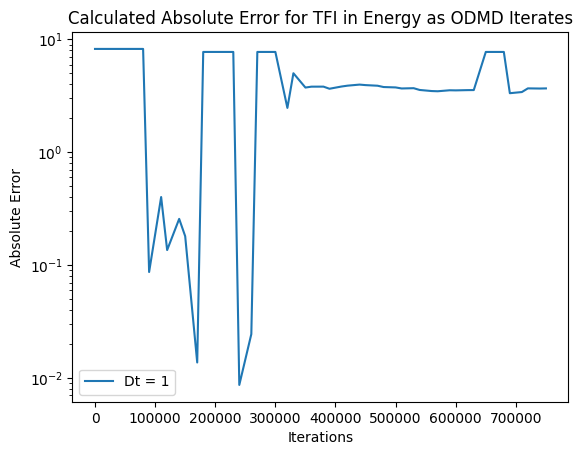

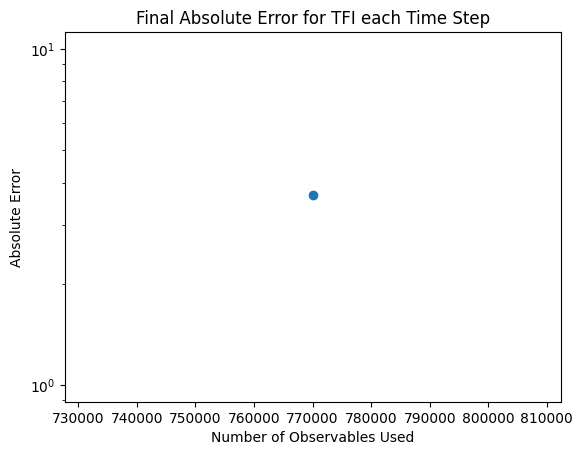

In [ ]:
for i in range(len(trials)):
    total_shots = [(w+math.floor(1/2*(w+1)))*parameters['shots'] for w in range(len(trials[i]))]
    err = [abs(w-real_E_0) for w in trials[i]]
    label = 'Dt = '+str(time_steps[i])
    plt.plot(total_shots, err, label = label)
plt.title("Calculated Absolute Error for "+system+" in Energy as ODMD Iterates")
plt.ylabel("Absolute Error")
plt.xlabel("Iterations")
plt.legend()
# plt.xlim([0,10])
# plt.ylim([0,10])
plt.yscale('log')
plt.savefig("Graphs/"+make_filename(computation_type, max_iterations, parameters)+"_shots"+str(parameters['shots'])+"_Abs_Error.png")
plt.show()

plt.title("Final Absolute Error for "+system+" each Time Step")
plt.xlabel("Number of Observables Used")
plt.ylabel("Absolute Error")
plt.yscale('log')
total_shots = [(len(w)+math.floor(1/2*(len(w)+1)))*parameters['shots'] for w in trials]
for i in range(len(results)):
    plt.scatter([total_shots[i]], [abs(real_E_0-results[i])], label = 'Dt = '+str(time_steps[i]))
plt.savefig("Graphs/"+make_filename(computation_type, max_iterations, parameters)+"_shots"+str(parameters['shots'])+"_Final_Error.png")
# plt.legend()
plt.show()

In [91]:
print(len(results))
print(time_steps)
print(results) 

1
[1]
[-11.929414891314954]
